# Multiple Objectives for Residential PV

## Set up.

### Import packages.

In [4]:
import os
import sys
sys.path.insert(0, os.path.abspath("../.."))

In [5]:
import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import seaborn           as sb
import tyche             as ty

In [8]:
print(sb.__version__)

0.11.0


NameError: name 'Figure' is not defined

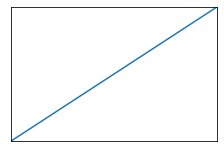

In [29]:
fig, ax = pl.subplots(figsize=(3, 2), constrained_layout=True)
# ax.set_title('title')
# ax.set_ylabel('y label')
# ax.set_xlabel('x label')
ax.plot([0,1], [0,1], label='my text here')
# ax.legend(loc='center left')
ax.set(
            xlabel="", ylabel="",
            yticks=[],
            yticklabels=[],
            xticks=[],
            xticklabels=[],
            # xlim=(y0-dy, y1+dy),
        )
pl.rcParams['axes.xmargin'] = 0
pl.rcParams['axes.ymargin'] = 0
pl.show()
# ax.margins(x=0)
# fig.subplots_adjust(left=0,right=1,bottom=0,top=1)

# Seaborn Examples

In [ ]:
tips = sb.load_dataset("tips")
sb.violinplot(data=tips, x="day", y="total_bill")

In [ ]:
# (fig,axes) = pl.subplots(1,3,sharey=True,figsize=(6,2))

penguins = sb.load_dataset("penguins")
# sb.displot(penguins, x="flipper_length_mm")
# sb.displot(penguins, x="flipper_length_mm", hue="species", stat="probability")
# sb.displot(penguins, x="flipper_length_mm", hue="species", kind="kde")
sb.displot(penguins, x="flipper_length_mm", hue="species", kind="hist", multiple="stack")
# sb.displot(penguins, x="flipper_length_mm", hue="species", kind="hist", multiple="stack")
# penguins

## Prepare data.

In [ ]:
# Prepare data.
# The data are stored in a set of tab-separated value files in a folder.
# Compile the production and metric functions for each technology in the dataset.
designs = ty.Designs("../../../data/residential_pv_multiobjective")
investments = ty.Investments("../../../data/residential_pv_multiobjective")
designs.compile()

# Multi-objective decision analysis.

# Compute costs and metrics for tranches.
# Tranches are atomic units for building investment portfolios. Evaluate all of the tranches,
# so we can assemble them into investments (portfolios).
tranche_results = investments.evaluate_tranches(designs, sample_count=50)

# Fit a response surface to the results.
# The response surface interpolates between the discrete set of cases provided in the expert elicitation.
# This allows us to study f
# unding levels intermediate between those scenarios.
evaluator = ty.Evaluator(investments.tranches, tranche_results.summary)

# Example investment.
# Let's evaluate the case where each category is invested in at half of its maximum amount.
example_investments = evaluator.max_amount / 2
evaluation = evaluator.evaluate(example_investments)

### Functions
- Aggregate over a given index
- Normalize to the maximum sample taken or to the maximum *mean sample*. This will be used to color heat maps

In [ ]:
def aggregate_over(ser, idx, statistic = np.mean):
    ser = ser.astype("float64")
    idx_res = list(set(ser.index.names.copy()) - set(idx))
    return ser.groupby(idx_res).aggregate(statistic)

def normalize_to_metric(x):
    x_mean = aggregate_over(x, ['Sample'])
    met_diff = (metric_range['Value Max'] - metric_range['Value Min'])
    return x_mean / met_diff

    
def normalize_to_max_sample(x):
    x_mean = aggregate_over(x, ['Sample'])
    x_max = aggregate_over(abs(x), ['Sample','Category'], np.max)
    return x_mean / x_max

def normalize_to_max_mean(x):
    x_mean = aggregate_over(evaluation, ['Sample'])
    x_max = aggregate_over(abs(x_mean), ['Category'], np.max)
    return x_mean / x_max

In [ ]:
def label_metric(evaluator, met):
    return str(met + "\n" + label_units(evaluator,met))
def label_units(evaluator, met):
    return str(evaluator.units.loc[met][0]).replace("CO2", "CO$_2$")

In [ ]:
met='GHG'
label_units(evaluator, met)
# "CO2" in label_units(evaluator, met)


# Plots

In [ ]:
pl.rcParams.update({
    'font.size': 20,
    'mathtext.default': 'regular',
})
SCALE=1.5
LINEWIDTH=1

mets = list(evaluator.metrics);          M = len(mets)
cats = list(example_investments.index);  C = len(cats)

eere_color_lst = ["#6ABC45", "#FFCB06", "#00A8DF"]
eere_color = dict(zip(cats, eere_color_lst))

In [ ]:
example_investments.index

In [ ]:
ser_norm = normalize_to_max_sample(evaluation)
ser_norm = ser_norm.unstack(level = 'Index')

ser_mean = aggregate_over(evaluation, ['Sample'])
ser_mean = ser_mean.unstack(level = 'Index')

(fig,ax) = pl.subplots(1,1,figsize=(9,6))

ax = sb.heatmap(ser_norm, linewidths=0.5,
    vmax=1.0, vmin=-1.0,
    cmap="coolwarm_r")

ax.xaxis.set_ticks_position('top')
pl.yticks(rotation=0)
pl.ylabel('')
pl.xlabel('')

fig.set_tight_layout(True)

pl.savefig("../assets/heatmap.png")

In [ ]:
ser_norm = normalize_to_max_sample(evaluation)
ser_norm = ser_norm.unstack(level = 'Index')

ser_mean = aggregate_over(evaluation, ['Sample'])
ser_mean = ser_mean.unstack(level = 'Index')

(fig,ax) = pl.subplots(1,1,figsize=(9,6))
ax = sb.heatmap(
    ser_norm,
    linewidths=0.5,
    vmax=1.0,
    vmin=-1.0,
    annot=ser_mean,
    fmt=".4g",
    cmap="coolwarm_r",
    ax=ax,
)

# ax.set(
#     xlabel="", ylabel="", yticks=[], yticklabels=[], xticks=[], xticklabels=[],
# )

ax.xaxis.set_ticks_position('top')
pl.yticks(rotation=0)
pl.ylabel('')
pl.xlabel('')

fig.set_tight_layout(True)
pl.savefig("../assets/heatmap_annotated.png")

In [ ]:
(fig,ax) = pl.subplots(1,M,sharey=False,figsize=(2*(C+1),M*0.75))
for ii in range(M):
    data = evaluation.xs(mets[ii], level = "Index"
            ).astype("float64").reset_index()

    sb.kdeplot(data=data, x="Value", hue="Category", multiple="stack", ax=ax[ii], palette=eere_color_lst)
    ax[ii].set(
        title = mets[ii],
        xlabel = label_units(evaluator, mets[ii]),
        ylabel = "",
        yticklabels = [],
    )
    # handles, labels = myax.get_legend_handles_labels()
    # ax[ii].legend(loc='upper-left')
    # print(labels)

# h,l = ax[0].get_legend_handles_labels

# fig.legend(labels=cats, loc='lower center')
# labels
# pl.rcParams['axes.prop_cycle'] = pl.cycler(color=["#6ABC45", "#FFCB06", "#00A8DF"])

In [ ]:
SIZE = (SCALE*2*(C+1), SCALE*M*0.75)

for typ in ["box"]:
    if typ == "kde": (fig,ax) = pl.subplots(1,M, figsize=SIZE)
    else:            (fig,ax) = pl.subplots(1,M, figsize=SIZE, sharey=True)

    for ii in range(M):
        data = evaluation.xs(mets[ii], level = "Index"
            ).astype("float64").reset_index()
        if typ == "box":
            sb.boxplot(y = 'Category', x = 'Value', data = data, ax = ax[ii], palette=eere_color_lst, linewidth=LINEWIDTH)
        elif typ == "violin":
            sb.violinplot(y = 'Category', x = 'Value', data = data, ax = ax[ii], palette=eere_color_lst, linewidth=LINEWIDTH)
        elif typ == "kde":
            sb.kdeplot(data=data, x="Value", hue="Category", multiple="stack", ax=ax[ii], legend=False, fill=True, linewidth=LINEWIDTH, alpha=0.5, palette=eere_color_lst)
            ax[ii].set(
                # title = mets[ii],
                # xlabel = label_units(evaluator, mets[ii]),
                # ylabel = "",
                yticks=[0],
                yticklabels = [],
            )
            ax[0].set(yticks=[0], yticklabels=["Inverter R&D"])
            # ax[0].set(yticks=[])

        ax[ii].set(
            title = mets[ii],
            xlabel = label_units(evaluator, mets[ii]),
            ylabel = "",
        )
    fig.set_tight_layout(True)
    # if typ == "kde": ax[0].set(yticklabels=[])

    fig.savefig("../assets/col_" + typ + ".png")

In [ ]:
typ = "box"
typ in ["box","distribution","violin"]

In [ ]:
metric_range = evaluator.min_metric.apply(lambda x: np.minimum(0, x)).join(
    evaluator.max_metric.apply(lambda x: np.maximum(0, x)),
    lsuffix=" Min",
    rsuffix=" Max",
)

m = evaluator.metrics[0]
c = evaluator.categories[0]

summary = evaluation.xs(m, level='Index').astype('float64')
values = summary.xs(c, level='Category').reset_index()
values_sum = summary.groupby("Sample").sum().reset_index()

y0 = min(0, metric_range.loc[m, "Value Min"])
y1 = max(0, metric_range.loc[m, "Value Max"])
dy = (y1 - y0) / 20

# sb.boxplot(data=values, x='Value')
# sb.violinplot(x='Value', data=values)
# sb.kdeplot(x='Value', data=values)

In [ ]:
typ = "violin"

LINEWIDTH=1
SCALE=1.5
SIZE=(SCALE*2*(C+1), SCALE*M)

if typ == "kde": (fig,ax) = pl.subplots(C,M, figsize=SIZE, sharex='col', sharey='col')
else:            (fig,ax) = pl.subplots(C,M, figsize=SIZE, sharex='col')

for mm in range(M):
    data_metric = evaluation.xs(mets[mm], level = "Index"
        ).astype("float64")

    for cc in range(C):
        data = data_metric.xs(cats[cc], level = "Category").reset_index()
        ax[cc,mm].set(xlabel=label_units(evaluator, mets[mm]))
        ax[cc,mm].set_ylabel(cats[cc],rotation=0,ha='right')

        if typ == "box":
            sb.boxplot(
                x='Value',
                data=data,
                ax=ax[cc,mm],
                # linewidth=LINEWIDTH,
                )
        elif typ == "violin":
            sb.violinplot(
                x='Value',
                data=data,
                ax=ax[cc,mm],
                # linewidth=LINEWITH,
                )
        elif typ == "kde":
            sb.kdeplot(
                x='Value',
                data=data,
                ax=ax[cc,mm],
                legend=False,
                fill=True,
                linewidth=LINEWIDTH,
                color=eere_color[cats[cc]],
                alpha=0.5,
                edgecolor='k')
            # ax[cc,mm].set(yticks=[0], yticklabels=["Inverter R&D"])

        ax[cc,mm].label_outer()
    ax[0,mm].set(title=mets[mm])

fig.savefig("../assets/grid_" + typ + ".png")